In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

In [50]:
folder_path = "samples_data"
batch_size = 64
epochs = 125
lr = 0.001
num_layers = 2
hidden_size= 128
input_size = 2 #non si considera la y
output_size = 2 #non si considera la y
past_seconds = 2
future_seconds = 4
framerate = 10

In [29]:
class CustomDataset1(Dataset):
    def __init__(self, folder_path, past_seconds=2, future_seconds=4, framerate=10):
        self.folder_path = folder_path
        self.npz_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]
        self.past_frames = framerate * past_seconds
        self.future_frames = framerate * future_seconds

    def __len__(self):
        return len(self.npz_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.npz_files[idx])
        data = np.load(file_path)

        # Converte i dati in tensori PyTorch
        past_trajectory = torch.tensor(np.delete(data["past_trajectory"], 1, 1), dtype=torch.float32)
        future_trajectory = torch.tensor(np.delete(data["future_trajectory"], 1, 1), dtype=torch.float32) 
        #past_trajectory = torch.tensor(data["past_trajectory"], dtype=torch.float32)
        #future_trajectory = torch.tensor(data["future_trajectory"], dtype=torch.float32)

        past_trajectory = past_trajectory[-self.past_frames:]
        future_trajectory = future_trajectory[:self.future_frames]

        return past_trajectory, future_trajectory

In [38]:
class MyGRU(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, output_size=2, num_layers=2, future_steps=40):
        super(MyGRU, self).__init__()
        self.hidden_size  = hidden_size
        self.num_layers = num_layers
        self.future_steps = future_steps
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, h = self.gru(x[:, :-1, :], h0) # out contiene tutti gli hidden state (dell'ultimo layer della GRU) di tutta la sequenza 
                                 # ed ha quindi dimensione [batch_size, seq_length=20, hidden_dim]
                                 # h contiene l'ultimo hidden state della sequenza di ogni layer della GRU, ed ha dimensione
                                 # [num_layers, batch_size, hidden_dim]
        
        future_trajectory_pred = []
        last_input = x[:, -1, :]  # ultimo punto della traiettoria passata ([batch_size, input_size])

        for _ in range(self.future_steps): 
            last_input = last_input.unsqueeze(1) #la dimensione ora è [batch_size, 1, input_size]
            out, h = self.gru(last_input, h)
            future_point = self.fc(out.squeeze(1)) # predizione punto successivo
            future_trajectory_pred.append(future_point)
            last_input = future_point # il punto successivo predetto diventa l'ultimo input
             
        return torch.stack(future_trajectory_pred, dim=1)

In [31]:
def train(model, device, train_loader, optimizer, epoch):
    model.train() # setta il modello in training mode
    lambda_x = 1/0.22
    lambda_z = 1/4.45
    train_mse_x = 0
    train_mse_z = 0
    train_mse_total = 0
    total_samples = 0

    for past, future in train_loader: # iterazione sui batch
        past, future = past.to(device), future.to(device) #spostamento traiettoria passata e futura sulla GPU
        optimizer.zero_grad() #azzera i gradienti

        future_pred = model(past) #viene eseguito il forward

        #calcolo delle loss, con la somma per normalizzare
        loss_x = F.mse_loss(future_pred[:, :, 0], future[:, :, 0], reduction='sum') # MSE su x
        loss_z = F.mse_loss(future_pred[:, :, -1], future[:, :, -1], reduction='sum') # MSE su z
        loss_total = lambda_x * loss_x + lambda_z * loss_z   
        
        train_mse_x += loss_x.item()
        train_mse_z += loss_z.item()
        train_mse_total += loss_total.item()

        loss_total.backward() # calcola i gradienti
        optimizer.step() # aggiorna i pesi

        total_samples += future.size(0) * future.size(1)  # numero totale di punti della traiettoria

    # normalizzazione per ottenere la media
    train_mse_x /= total_samples
    train_mse_z /= total_samples
    train_mse_total /= total_samples

    print(f'Train Epoch {epoch}: MSE Total = {train_mse_total:.6f},   MSE X = {train_mse_x:.6f},   MSE Z = {train_mse_z:.6f}')
    
    return train_mse_total, train_mse_x, train_mse_z

In [32]:
def test(model, device, test_loader):
    model.eval() #setta il modello in evaluation mode
    lambda_x = 1/0.22
    lambda_z = 1/4.45
    test_mse_x, test_mse_z, test_mse_total = 0, 0, 0
    total_samples = 0

    with torch.no_grad():
        for past, future in test_loader:
            past, future = past.to(device), future.to(device)
            future_pred = model(past)

            loss_x = F.mse_loss(future_pred[:, :, 0], future[:, :, 0], reduction='sum')  # MSE su x
            loss_z = F.mse_loss(future_pred[:, :, -1], future[:, :, -1], reduction='sum')  # MSE su z
            loss_total = lambda_x * loss_x + lambda_z * loss_z  
            
            test_mse_x += loss_x.item()
            test_mse_z += loss_z.item()
            test_mse_total += loss_total.item()

            total_samples += future.size(0) * future.size(1)

    # normalizzazione per ottenere la media
    test_mse_x /= total_samples
    test_mse_z /= total_samples
    test_mse_total /= total_samples

    print(f'Test: MSE Total = {test_mse_total:.6f},   MSE X = {test_mse_x:.6f},   MSE Z = {test_mse_z:.6f}')
    return test_mse_total, test_mse_x, test_mse_z

In [64]:
import matplotlib.pyplot as plt

def plot_loss(epochs, train_losses_total, test_losses_total, train_losses_x, test_losses_x, train_losses_z, test_losses_z):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 riga, 3 colonne

    # Plot per la loss totale
    axes[0].plot(range(1, epochs + 1), train_losses_total, marker='o', color='red', label="Train Total loss")
    axes[0].plot(range(1, epochs + 1), test_losses_total, marker='o', color='blue', label="Test Total loss")
    axes[0].set_xticks([1] + list(range(10, epochs + 1, 10)))
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].set_title('Total Loss')

    # Plot per la loss su X
    axes[1].plot(range(1, epochs + 1), train_losses_x, marker='o', color='red', label="Train X loss")
    axes[1].plot(range(1, epochs + 1), test_losses_x, marker='o', color='blue', label="Test X loss")
    axes[1].set_xticks([1] + list(range(10, epochs + 1, 10)))
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].set_title('X Loss')

    # Plot per la loss su Z
    axes[2].plot(range(1, epochs + 1), train_losses_z, marker='o', color='red', label="Train Z loss")
    axes[2].plot(range(1, epochs + 1), test_losses_z, marker='o', color='blue', label="Test Z loss")
    axes[2].set_xticks([1] + list(range(10, epochs + 1, 10)))
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].set_title('Z Loss')

    plt.tight_layout()  # Per evitare sovrapposizioni
    plt.show()

In [34]:
dataset = CustomDataset1(folder_path=folder_path, past_seconds=past_seconds, future_seconds=future_seconds, 
                         framerate=framerate)
torch.manual_seed(42) # per avere lo stesso split di train/test ad ogni esecuzione
train_set, test_set = random_split(dataset, [0.75, 0.25])
train_loader = DataLoader(train_set, num_workers=2, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, num_workers=2, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
model = MyGRU(input_size=input_size, hidden_size=hidden_size, output_size=output_size, 
              num_layers=num_layers).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
old_weights = copy.deepcopy(model.state_dict()) #add

train_losses_x = []
train_losses_z = []
train_losses_total = []
test_losses_x = []
test_losses_z = []
test_losses_total = []

start_time = time.time()

for epoch in range(1, epochs + 1):
    #esegue un'epoca di training
    train_loss_total, train_loss_x, train_loss_z = train(model, device, train_loader, optimizer, epoch)
    test_loss_total, test_loss_x, test_loss_z = test(model, device, test_loader)

    if(epoch!=1 and test_loss_total - test_losses_total[-1] > 1): #add
        model.load_state_dict(old_weights)
        print("Early stopping applied!")
        break

    train_losses_total.append(train_loss_total)
    train_losses_x.append(train_loss_x)
    train_losses_z.append(train_loss_z)
    test_losses_total.append(test_loss_total)
    test_losses_x.append(test_loss_x)
    test_losses_z.append(test_loss_z)
    old_weights = copy.deepcopy(model.state_dict()) # add
    print("\n")

end_time = time.time()

execution_time = end_time - start_time

minutes, seconds = divmod(execution_time, 60) #converte il tempo in minuti e secondi

print(f"Execution time: {int(minutes)} minutes, {seconds:.2f} seconds")

Train Epoch 1: MSE Total = 2.793143,   MSE X = 0.560971,   MSE Z = 1.082583
Test: MSE Total = 2.612344,   MSE X = 0.555162,   MSE Z = 0.395518


Train Epoch 2: MSE Total = 2.532800,   MSE X = 0.533304,   MSE Z = 0.483685
Test: MSE Total = 2.380224,   MSE X = 0.464794,   MSE Z = 1.190472


Train Epoch 3: MSE Total = 1.724572,   MSE X = 0.356397,   MSE Z = 0.465402
Test: MSE Total = 1.688294,   MSE X = 0.355242,   MSE Z = 0.327335


Train Epoch 4: MSE Total = 1.383180,   MSE X = 0.286825,   MSE Z = 0.353466
Test: MSE Total = 1.409292,   MSE X = 0.292860,   MSE Z = 0.347584


Train Epoch 5: MSE Total = 1.333271,   MSE X = 0.278485,   MSE Z = 0.300066
Test: MSE Total = 1.196464,   MSE X = 0.251692,   MSE Z = 0.233226


Train Epoch 6: MSE Total = 1.293706,   MSE X = 0.270550,   MSE Z = 0.284509
Test: MSE Total = 1.202384,   MSE X = 0.250798,   MSE Z = 0.277650


Train Epoch 7: MSE Total = 1.251230,   MSE X = 0.260982,   MSE Z = 0.289014
Test: MSE Total = 1.202602,   MSE X = 0.251153,   MSE 

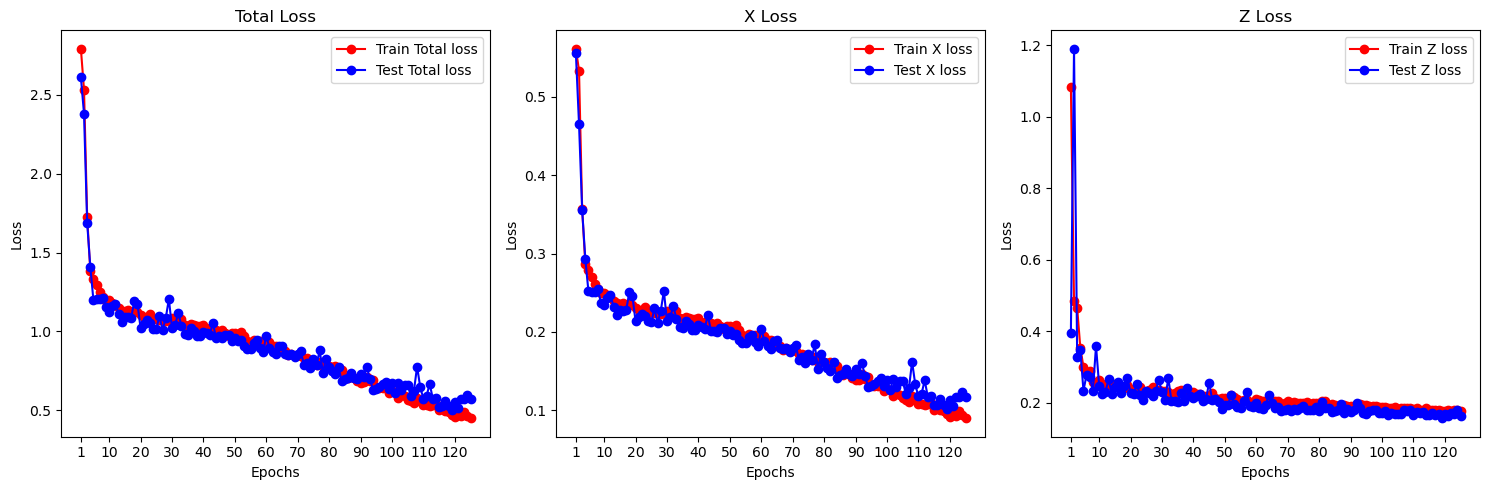

In [65]:
plot_loss(len(train_losses_total), train_losses_total, test_losses_total, train_losses_x, test_losses_x, train_losses_z, 
          test_losses_z)

In [ ]:
'''
all_variances_x = []
all_variances_y = []
all_variances_z = []

for past, future in train_set + test_set:
    x_values = torch.cat([past[:, 0], future[:, 0]])  # estrae le coordinate x dei punti del campione
    y_values = torch.cat([past[:, 1], future[:, 1]])  # estrae le coordinate y dei punti del campione
    z_values = torch.cat([past[:, 2], future[:, 2]])  # estrae le coordinate z dei punti del campione
    all_variances_x.append(torch.var(x_values))
    all_variances_y.append(torch.var(y_values))
    all_variances_z.append(torch.var(z_values))


# calcola la media delle varianze
mean_x_variance = torch.mean(torch.tensor(all_variances_x))
mean_y_variance = torch.mean(torch.tensor(all_variances_y))
mean_z_variance = torch.mean(torch.tensor(all_variances_z))

print(f"Media delle varianze di x per campione: {mean_x_variance.item()}") # 0.2217440903186798
print(f"Media delle varianze di y per campione: {mean_y_variance.item()}") # 0.0037309727631509304
print(f"Media delle varianze di z per campione: {mean_z_variance.item()}") # 4.453895092010498
'''

Media delle varianze di x per campione: 0.2217440903186798
Media delle varianze di y per campione: 0.0037309727631509304
Media delle varianze di z per campione: 4.453895092010498


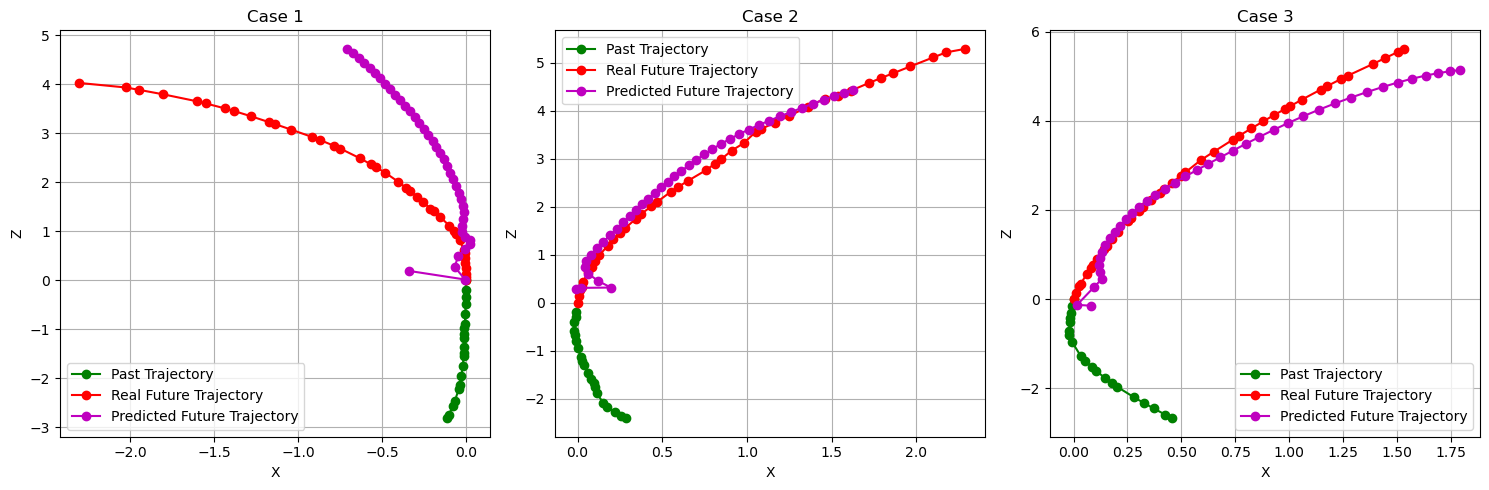

In [61]:
model.eval()
batch = next(iter(test_loader)) # prende un batch dal test_loader
past_batch, future_batch = batch  # estrae passato e futuro dal batch

# seleziona tre esempi diversi dal batch
indices = [3, 20, 59]  # indici di tre campioni
examples = [(past_batch[i], future_batch[i]) for i in indices]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (past, future) in enumerate(examples):
    past = past.cpu().numpy()
    future = future.cpu().numpy()

    # Predizione del modello
    past_tensor = past_batch[indices[i]].unsqueeze(0).to(device)  # prende un campione e aggiunge batch dim
    with torch.no_grad():
        predicted_future = model(past_tensor).squeeze(0).cpu().detach().numpy()  # predice e converte in numpy

    # Plot
    axes[i].plot(past[:, 0], past[:, 1], 'g-o', label="Past Trajectory") 
    axes[i].plot(future[:, 0], future[:, 1], 'r-o', label="Real Future Trajectory") 
    axes[i].plot(predicted_future[:, 0], predicted_future[:, 1], 'm-o', label="Predicted Future Trajectory") 
    
    axes[i].set_xlabel("X")
    axes[i].set_ylabel("Z")
    axes[i].set_title(f"Case {i+1}")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()